# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('facial-keypoints-detection/training.csv')

In [3]:
y_full = df.drop(columns=['Image']).values.astype(np.float32)
x_full = [[int(n) for n in img_str.split()] for img_str in df['Image']]
x_full = np.array(x_full, dtype=np.float32).reshape((-1, 96, 96, 1)) / 255

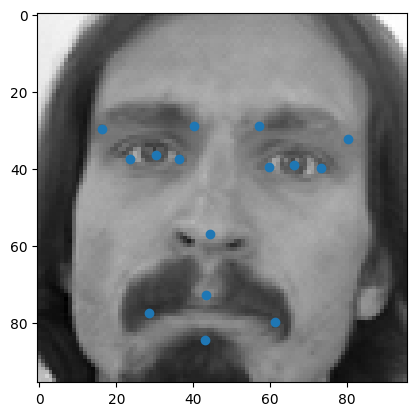

In [4]:
plt.imshow(x_full[0], cmap='grey')
key_points = y_full[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_full, 
    y_full,
    test_size=0.125,
    shuffle=True,
    random_state=0,
)

imputer = KNNImputer()
y_train_full = imputer.fit_transform(y_train_full)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, 
    y_train_full,
    test_size=0.15,
    shuffle=True,
    random_state=0,
)

print(f'{len(x_train)} train, {len(x_valid)} valid, {len(x_test)} test')

5241 train, 926 valid, 882 test


# Default Model

In [38]:
import tensorflow as tf
from keras import models, layers, losses, optimizers

In [39]:
def get_model(weights_path=None):
    model = models.Sequential((
        layers.Input(shape=(96, 96, 1)),
        layers.Conv2D(64, (3, 3), 
                    padding='same', 
                    activation=tf.nn.relu, 
                    use_bias=False),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3),
                    padding='same', 
                    activation=tf.nn.relu, 
                    use_bias=False),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), 
                    padding='same', 
                    activation=tf.nn.relu, 
                    use_bias=False),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(30),
    ))

    if weights_path:
        model.load_weights(weights_path)

    model.compile(loss=losses.mean_squared_error, 
                  metrics=[tf.metrics.R2Score()])

    return model

In [41]:
def batch_iterate(x, y, batch_size):
    permutation = np.random.permutation(y.shape[0])
    for s in range(0, y.shape[0], batch_size):
        idxs = permutation[s:s + batch_size]
        yield tf.convert_to_tensor(x[idxs]), tf.convert_to_tensor(y[idxs])

In [50]:
model = get_model('./checkpoints/model0.weights.h5')
optimizer = optimizers.Adam(learning_rate=0.001, weight_decay=0.1)


@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        l = model.loss(y, y_pred)
    grads = tape.gradient(l, model.trainable_variables)
    optimizer.apply(grads, model.trainable_variables)

In [43]:
# for epoch in range(100):
#     if (epoch + 1) % 10 == 0:
#         print('epoch:', epoch + 1)
#     for x, y in batch_iterate(x_train, y_train, batch_size=100):
#         train_step(x, y)
#     optimizer.learning_rate *= 0.99

# model.save_weights('./checkpoints/model1.weights.h5')

In [44]:
_ = model.evaluate(x_valid, y_valid)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4927 - r2_score: 0.5504


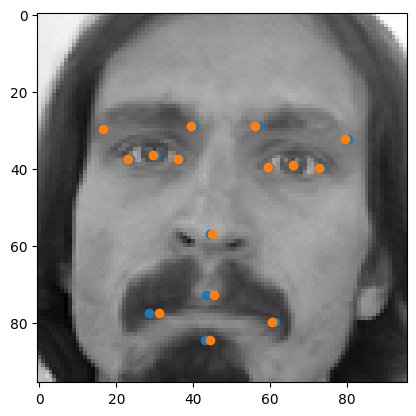

In [45]:
plt.imshow(x_full[0], cmap='grey')
y_pred = model(x_full[0:1]).numpy()
key_points = y_full[0].reshape((-1, 2))
key_points_pred = y_pred[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.scatter(key_points_pred[:, 0], key_points[:, 1])
plt.show()

# Attacking the Model

In [46]:
def fgsm(model, x, y, eps):
    delta = tf.Variable(tf.zeros_like(x))
    with tf.GradientTape() as tape:
        y_pred = model(x + delta)
        l = model.loss(y, y_pred)
    grad = tape.gradient(l, delta)
    return eps * tf.sign(grad)

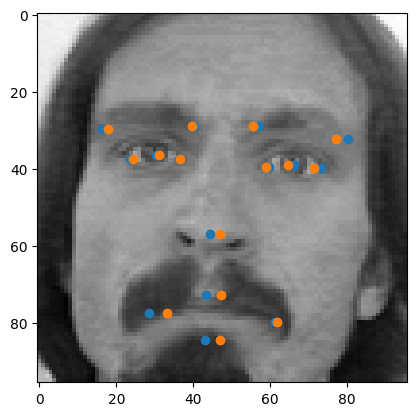

In [47]:
delta = fgsm(model, x_full[:1], y_full[:1], 0.01)

plt.imshow(x_full[0] + delta[0], cmap='grey')
y_pred = model(x_full[:1] + delta).numpy()
key_points = y_full[0].reshape((-1, 2))
key_points_pred = y_pred[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.scatter(key_points_pred[:, 0], key_points[:, 1]) 
plt.show()

In [48]:
def pgd(model, x, y, eps, alpha=0.001, n_iters=100):
    delta = tf.Variable(tf.zeros_like(x))

    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            y_pred = model(x + delta)
            l = model.loss(y, y_pred)
        grad = tape.gradient(l, delta)
        delta.assign_add(alpha * grad)
        delta.assign(tf.clip_by_value(delta, -eps, eps))
    

    for _ in range(n_iters):
        train_step()

    return delta.value()

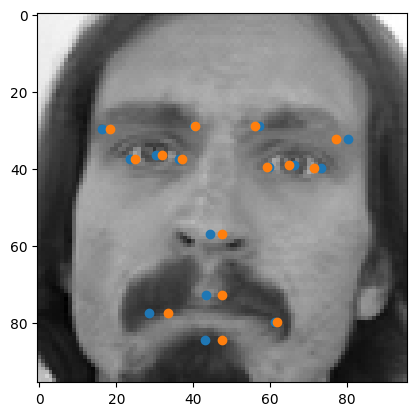

In [49]:
delta = pgd(model, x_full[:1], y_full[:1], 0.01)

plt.imshow(x_full[0] + delta[0], cmap='grey')
y_pred = model(x_full[:1] + delta).numpy()
key_points = y_full[0].reshape((-1, 2))
key_points_pred = y_pred[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.scatter(key_points_pred[:, 0], key_points[:, 1])
plt.show()

In [37]:
x_valid_fgsm = x_valid + fgsm(model, x_valid, y_valid, 0.01)
x_valid_pgd = x_valid  + pgd(model, x_valid, y_valid, 0.01)

print('no attack:')
_ = model.evaluate(x_valid, y_valid)
print('fgsm attack:')
_ = model.evaluate(x_valid_fgsm, y_valid)
print('pgd attack:')
_ = model.evaluate(x_valid_pgd, y_valid)

no attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4927 - r2_score: 0.5504
fgsm attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 11.2356 - r2_score: -0.0751
pgd attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.5149 - r2_score: -0.2711


# Robust Model

In [85]:
model = get_model()
optimizer = optimizers.Adam(learning_rate=0.001, weight_decay=0.1)
delta = tf.Variable(tf.zeros((1, 96, 96, 1)))        
eps = tf.Variable(0.0025)


@tf.function
def adversarial_train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        l = model.loss(y, y_pred)
    grads = tape.gradient(l, model.trainable_variables)
    optimizer.apply(grads, model.trainable_variables)

    delta.assign(tf.zeros_like(delta))
    with tf.GradientTape() as tape:
        y_pred = model(x + delta)
        l = model.loss(y, y_pred)
    grad = tape.gradient(l, delta)
    x += eps * tf.sign(grad)

    with tf.GradientTape() as tape:
        y_pred = model(x)
        l = model.loss(y, y_pred)
    grads = tape.gradient(l, model.trainable_variables)
    optimizer.apply(grads, model.trainable_variables)

In [86]:
x_valid_fgsm = x_valid + fgsm(model, x_valid, y_valid, 0.01)

print('no attack:')
_ = model.evaluate(x_valid, y_valid)
print('fgsm attack:')
_ = model.evaluate(x_valid_fgsm, y_valid)

no attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.8127 - r2_score: 0.2394
fgsm attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7586 - r2_score: 0.1547


In [87]:
for epoch in range(100):
    if (epoch + 1) % 5 == 0:
        print('epoch:', epoch + 1)
    for x, y in batch_iterate(x_train, y_train, batch_size=1):
        adversarial_train_step(x, y)
    optimizer.learning_rate *= 0.99
    eps.assign(eps * 1.1)

model.save_weights('./checkpoints/robust_model2.weights.h5')

epoch: 5
epoch: 10
epoch: 15
epoch: 20


In [88]:
x_valid_fgsm = x_valid + fgsm(model, x_valid, y_valid, 0.01)

print('no attack:')
_ = model.evaluate(x_valid, y_valid)
print('fgsm attack:')
_ = model.evaluate(x_valid_fgsm, y_valid)

no attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.9131 - r2_score: 0.3292
fgsm attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1150 - r2_score: 0.2201


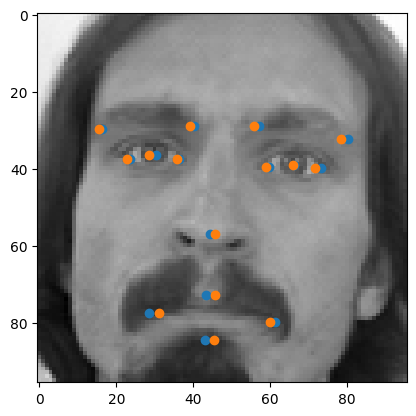

In [89]:
plt.imshow(x_full[0], cmap='grey')
y_pred = model(x_full[0:1]).numpy()
key_points = y_full[0].reshape((-1, 2))
key_points_pred = y_pred[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.scatter(key_points_pred[:, 0], key_points[:, 1])
plt.show()

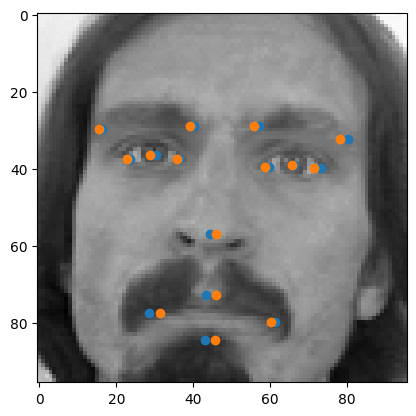

In [90]:
delta = fgsm(model, x_full[:1], y_full[:1], 0.01)

plt.imshow(x_full[0] + delta[0], cmap='grey')
y_pred = model(x_full[:1] + delta).numpy()
key_points = y_full[0].reshape((-1, 2))
key_points_pred = y_pred[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.scatter(key_points_pred[:, 0], key_points[:, 1]) 
plt.show()